### Описание проекта
Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!
Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:
Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).
С помощью модели нужно отобрать коров по двум критериям:
средний удой за год — не менее 6000 килограммов;
молоко должно быть вкусным.

In [1]:
#импортирую все библиотеки и модули тут
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, \
    recall_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Загрузка данных

In [2]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')

In [3]:
def get_info(data):
    display(data.head())
    print('')
    display(data.info())
    print('')
    display(data.describe().T)
    print('')
    print('-----')
    print('Кол-во явных дубликатов:', data.duplicated().sum())
    print('Кол-во пропусков:\n', data.isna().sum())
    print('-----')

In [4]:
get_info(ferma_main)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возра

None

,count,mean,std,min,25%,50%,75%,max
id,634.0,317.460568,183.096982,1.000,159.250,317.500,475.750,629.000
"Удой, кг",634.0,6187.025237,1638.401021,5204.000,5751.750,6130.500,6501.000,45616.000
ЭКЕ (Энергетическая кормовая единица),634.0,14.542744,1.301301,10.900,13.500,14.700,15.600,16.800
"Сырой протеин, г",634.0,1922.682965,182.392548,1660.000,1772.250,1880.500,2058.750,2349.000
СПО (Сахаро-протеиновое соотношение),634.0,0.912855,0.032209,0.840,0.890,0.930,0.940,0.960
"Жирность,%",634.0,3.603943,0.168020,2.990,3.590,3.650,3.720,3.750
"Белок,%",634.0,3.075666,0.002540,3.069,3.074,3.076,3.077,3.085



-----
Кол-во явных дубликатов: 5
Кол-во пропусков:
 id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
порода папы_быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64
-----


In [5]:
get_info(ferma_dad)

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,629.0,315.0,181.72094,1.0,158.0,315.0,472.0,629.0



-----
Кол-во явных дубликатов: 0
Кол-во пропусков:
 id          0
Имя Папы    0
dtype: int64
-----


In [6]:
get_info(cow_buy)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

,count,mean,std,min,25%,50%,75%,max
"Текущая_жирность,%",20.0,3.5775,0.126818,3.340,3.510,3.590,3.650,3.770
"Текущий_уровень_белок,%",20.0,3.0695,0.010339,3.046,3.064,3.074,3.076,3.081



-----
Кол-во явных дубликатов: 4
Кол-во пропусков:
 Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64
-----


Вывод по общей информации о данных:

- ferma_main

-Обнаружено 5 явных дубликатов (в дальнейшем удалю их)

-Стоит изменить названия столбцов и привести их к единому виду

-Пропущенных значений не выявлено

-С типами данных все в порядке

- ferma_dad

-Стоит изменить названия столбцов и привести их к единому виду

-В остальном данные в порядке и готовы для использования

- cow_buy

-Обнаружено 4 явных дубликата (убирать их не буду, поскольку данных в датасете мало, как и признаков. Вполне вероятно, что данные и признаки сходятся для разных коров)

-Стоит изменить названия столбцов и привести их к единому виду

-Пропущенных значений не выявлено

-С типами данных все в порядке

##  Предобработка данных

### Переименование столбцов

In [7]:
ferma_main.rename(columns={
    'Удой, кг': 'удой',
    'ЭКЕ (Энергетическая кормовая единица)': 'эке',
    'Сырой протеин, г': 'сырой_протеин',
    'СПО (Сахаро-протеиновое соотношение)': 'спо',
    'Порода': 'порода',
    'Тип пастбища': 'тип_пастбища',
    'порода папы_быка': 'порода_папы',
    'Жирность,%': 'жирность',
    'Белок,%': 'белок',
    'Вкус молока': 'вкус_молока',
    'Возраст': 'возраст',
}, inplace=True)

ferma_main.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [8]:
ferma_dad.rename(columns={'Имя Папы': 'имя_папы'}, inplace=True)
ferma_dad.head()

,id,имя_папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [9]:
cow_buy.rename(columns={
    'Порода': 'порода',
    'Тип пастбища': 'тип_пастбища',
    'порода папы_быка': 'порода_папы',
    'Имя_папы': 'имя_папы',
    'Текущая_жирность,%': 'текущая_жирность',
    'Текущий_уровень_белок,%': 'текущий_белок',
    'Возраст': 'возраст',
}, inplace=True)

cow_buy.head()

,порода,тип_пастбища,порода_папы,имя_папы,текущая_жирность,текущий_белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


### Обработка пропущенных значений

In [10]:
print(ferma_main.isna().sum())

id               0
удой             0
эке              0
сырой_протеин    0
спо              0
порода           0
тип_пастбища     0
порода_папы      0
жирность         0
белок            0
вкус_молока      0
возраст          0
dtype: int64


In [11]:
print(ferma_dad.isna().sum())

id          0
имя_папы    0
dtype: int64


In [12]:
print(cow_buy.isna().sum())

порода              0
тип_пастбища        0
порода_папы         0
имя_папы            0
текущая_жирность    0
текущий_белок       0
возраст             0
dtype: int64


In [13]:
#Замена пропусков на 0 в датафрейме ferma_main_df
ferma_main.fillna(0, inplace=True) 
print(ferma_main.isna().sum())

id               0
удой             0
эке              0
сырой_протеин    0
спо              0
порода           0
тип_пастбища     0
порода_папы      0
жирность         0
белок            0
вкус_молока      0
возраст          0
dtype: int64


In [14]:
#Удаление строк с пропущенными значениями 
ferma_dad.dropna(inplace=True) 

### Обработка дубликатов

In [15]:
# Выведем словарь, где ключ -> название столбца, а значение -> список уникальных значений столбцаunique_values_dict = {}
unique_values_dict = {}
for column in ferma_main.columns:
    if ferma_main[column].dtype == 'object':
        unique_values_dict[column] = ferma_main[column].unique()

print(unique_values_dict)

{'порода': array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object), 'тип_пастбища': array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object), 'порода_папы': array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object), 'вкус_молока': array(['вкусно', 'не вкусно'], dtype=object), 'возраст': array(['более_2_лет', 'менее_2_лет'], dtype=object)}


Выявила 2 неявных дубликата:

-"Равнинные" и "Равнинное" в столбце тип_пастбища

-"Айдиал" и "Айдиалл" в столбце порода_папы

In [16]:
# Заменю значения и после проверю:
ferma_main['тип_пастбища'].replace({'Равнинные': 'Равнинное'}, inplace=True)
ferma_main['порода_папы'].replace({'Айдиалл': 'Айдиал'}, inplace=True)

display(ferma_main['тип_пастбища'].unique())
ferma_main['порода_папы'].unique()
ferma_main.head()

array(['Равнинное', 'Холмистое'], dtype=object)

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


In [17]:
ferma_dad['имя_папы'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

In [18]:
unique_values_dict = {}
for column in cow_buy.columns:
    if cow_buy[column].dtype == 'object':
        unique_values_dict[column] = cow_buy[column].unique()

print(unique_values_dict)

{'порода': array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object), 'тип_пастбища': array(['холмистое', 'равнинное'], dtype=object), 'порода_папы': array(['Айдиал', 'Соверин'], dtype=object), 'имя_папы': array(['Геркулес', 'Буйный', 'Барин', 'Соловчик'], dtype=object), 'возраст': array(['более_2_лет', 'менее_2_лет'], dtype=object)}


In [19]:
# Заменю значения и после проверю:
cow_buy['тип_пастбища'].replace({'холмистое': 'Холмистое', 'равнинное': 'Равнинное'}, inplace=True)
cow_buy.head()

,порода,тип_пастбища,порода_папы,имя_папы,текущая_жирность,текущий_белок,возраст
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [20]:
# Сбрасываем дубликаты с заменой
print('Кол-во дубликатов ДО удаления в датасете ferma_main:', ferma_main.duplicated().sum())

ferma_main.drop_duplicates(inplace=True)
print('---------')

# Проверка
print('Кол-во дубликатов ПОСЛЕ удаления в датасете ferma_main:', ferma_main.duplicated().sum())

Кол-во дубликатов ДО удаления в датасете ferma_main: 5
---------
Кол-во дубликатов ПОСЛЕ удаления в датасете ferma_main: 0


- Вывод по предобработке данных:

-Названия столбцов приведены к единому виду

-Убраны неявные дубликаты из датасета ferma_main и ferma_main



## Исследовательский анализ данных

In [21]:
display(ferma_main.head())
ferma_main.describe().T

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


,count,mean,std,min,25%,50%,75%,max
id,629.0,315.000000,181.720940,1.000,158.000,315.000,472.000,629.000
удой,629.0,6188.750397,1644.795489,5204.000,5751.000,6133.000,6501.000,45616.000
эке,629.0,14.543879,1.306408,10.900,13.500,14.700,15.600,16.800
сырой_протеин,629.0,1923.364070,182.956251,1660.000,1771.000,1888.000,2062.000,2349.000
спо,629.0,0.913116,0.032203,0.840,0.890,0.930,0.940,0.960
жирность,629.0,3.603657,0.168656,2.990,3.590,3.650,3.720,3.750
белок,629.0,3.075671,0.002549,3.069,3.074,3.076,3.077,3.085


Из данных можно проследить странное макисмальное значение "удоя", так как корова не дает примерно 45-46 тонн молока в год

### Количественные признаки

In [22]:
#признак "удой"
ferma_main['удой'].sort_values(ascending=False).head()

16     45616
70      7222
135     7207
296     7201
294     7197
Name: удой, dtype: int64

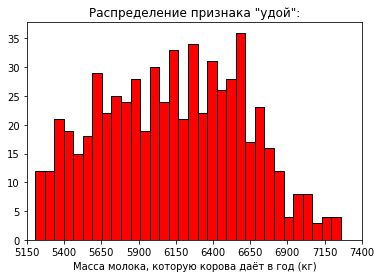

In [23]:
plt.hist(ferma_main['удой'], color='red', edgecolor='black', bins=629)
plt.xlim(5204, 7222)
plt.xticks(np.arange(5150, 7450, 250))
plt.title('Распределение признака "удой":')
plt.xlabel('Масса молока, которую корова даёт в год (кг)')
plt.show()

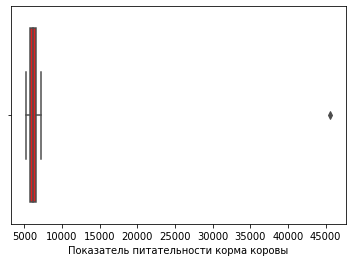

In [24]:
sns.boxplot(x=ferma_main['удой'], color='red')
plt.xlabel('Показатель питательности корма коровы')
plt.show()

можно заметить аномальное значение, оно является недостоверным, поэтому избавлюсь от него

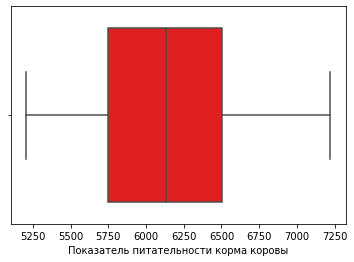

In [25]:
ferma_main = ferma_main.query('удой != 45616')
sns.boxplot(x=ferma_main['удой'], color='red')
plt.xlabel('Показатель питательности корма коровы')
plt.show()

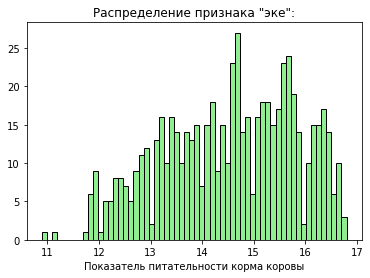

In [26]:
#признак "эке"
plt.hist(ferma_main['эке'], color='Lightgreen', edgecolor='black', bins=60)
plt.title('Распределение признака "эке":')
plt.xlabel('Показатель питательности корма коровы')
plt.show()

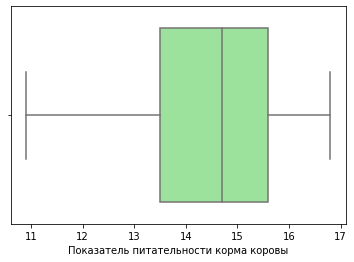

In [27]:
sns.boxplot(x=ferma_main['эке'], color='Lightgreen')
plt.xlabel('Показатель питательности корма коровы')
plt.show()

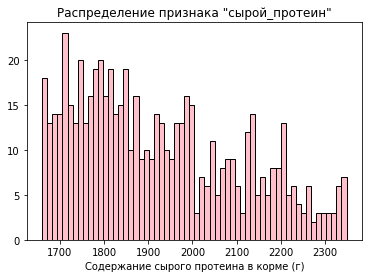

In [28]:
#признак "сырой протеин"
plt.hist(ferma_main['сырой_протеин'], color='pink', edgecolor='black', bins=60)
plt.title('Распределение признака "сырой_протеин"')
plt.xlabel('Содержание сырого протеина в корме (г)')
plt.show()

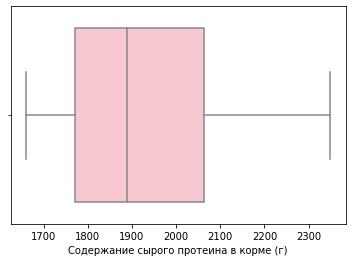

In [29]:
sns.boxplot(x=ferma_main['сырой_протеин'], color='pink')
plt.xlabel('Содержание сырого протеина в корме (г)')
plt.show()

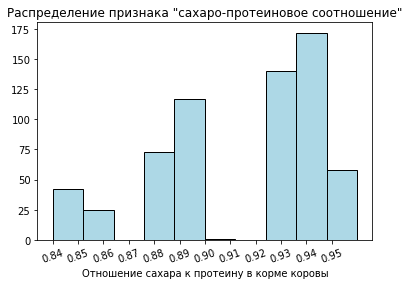

In [30]:
#признак "спо"
plt.hist(ferma_main['спо'], color='Lightblue', edgecolor='black', bins=10)
plt.xticks(np.arange(0.84, 0.96, 0.01), rotation=20)
plt.title('Распределение признака "сахаро-протеиновое соотношение"')
plt.xlabel('Отношение сахара к протеину в корме коровы')
plt.show()

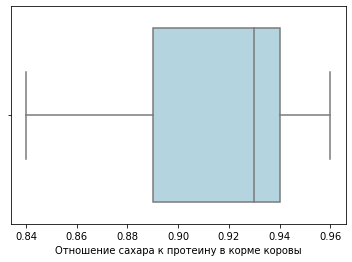

In [31]:
sns.boxplot(x=ferma_main['спо'], color='Lightblue')
plt.xlabel('Отношение сахара к протеину в корме коровы')
plt.show()

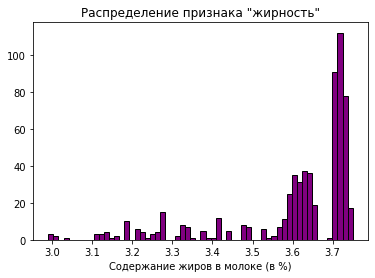

In [32]:
#признак "жирность" 
plt.hist(ferma_main['жирность'], color='purple', edgecolor='black', bins=60)
plt.title('Распределение признака "жирность"')
plt.xlabel('Cодержание жиров в молоке (в %)')
plt.show()

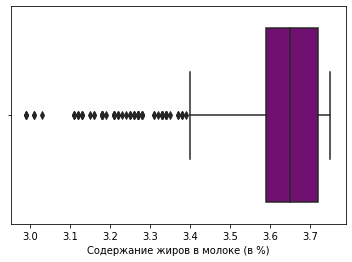

In [33]:
sns.boxplot(x=ferma_main['жирность'], color='purple')
plt.xlabel('Cодержание жиров в молоке (в %)')
plt.show()

Можно заметить, что имеются выбросы. Проверю их долю и дальше решу, что с ними делать

In [34]:
print(round(len(ferma_main.query("жирность < 3.4")) / len(ferma_main) * 100, 3), "%")

13.694 %


доля выбрасов оказалось не маленькой, поэтому удалять или заменять медианным значением не буду, оставлю как есть

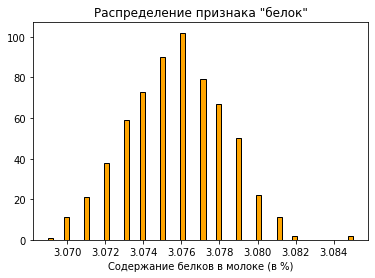

In [35]:
#признак "белок"
plt.hist(ferma_main['белок'], color='orange', edgecolor='black', bins=60)
plt.title('Распределение признака "белок"')
plt.xlabel('Cодержание белков в молоке (в %)')
plt.show()

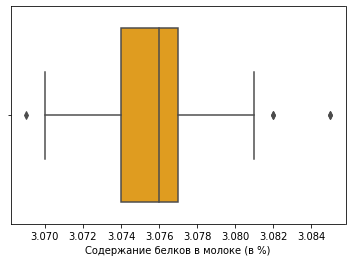

In [36]:
sns.boxplot(x=ferma_main['белок'], color='orange')
plt.xlabel('Cодержание белков в молоке (в %)')
plt.show()

Имеются выбросы, которых как видно немного, поэтому избавлюсь от них

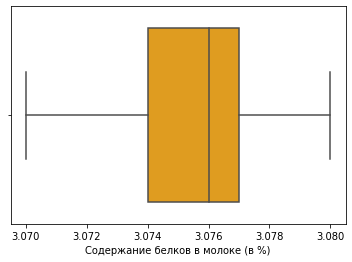

In [37]:
ferma_main = ferma_main.query('3.069 < белок < 3.081 ')
sns.boxplot(x=ferma_main['белок'], color='orange')
plt.xlabel('Cодержание белков в молоке (в %)')
plt.show()

#### Вывод по количественным признакам:
- Удой
Имелись выбросы, от которых избавилась. В остальном, распределение признака выглядит нормальным.
- Эке
Распределение признака - близкое к нормальному. Наблюдаются пиковые значения на отметках примерно 14.6 и 15.5
Ярких выбросов нет.
- Сырой протеин
Распределение признака - близкое к нормальному. Большая часть признака распределена в сторону значений < 2100. Не наблюдаются выбросы или аномальные значения
Большая часть признака приходится на значение отношения == 0.94. Аномальных значений и выбросов нет. Распределение не похоже на нормальное (это может быть специфика признака)
- Жирность
Доля выбросов в интеревале значений < 3.4 составляет 13.694%, что не мало. Доля таких выбросов довольнов связи с чем удалять подобные значения не стоит. Предлагаю оставить выбросы, так как их потеря / замена на медианное значение может негативно повлиять на качество данных

### Категориальные признаки

In [38]:
#признак "порода"
ferma_main['порода'].value_counts()

Вис Бик Айдиал     358
РефлешнСоверинг    254
Name: порода, dtype: int64

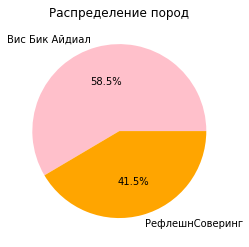

In [39]:
plt.pie(
    ferma_main['порода'].value_counts(),
    labels=['Вис Бик Айдиал ', 'РефлешнСоверинг'],
    autopct='%1.1f%%',
    colors=['pink', 'orange']
)
plt.title('Распределение пород')
plt.grid()
plt.show()

In [40]:
#признак "тип пастбища"
ferma_main['тип_пастбища'].value_counts()

Холмистое    341
Равнинное    271
Name: тип_пастбища, dtype: int64

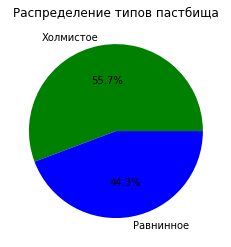

In [41]:
plt.pie(
    ferma_main['тип_пастбища'].value_counts(),
    labels=['Холмистое', 'Равнинное'],
    autopct='%1.1f%%',
    colors=['green', 'blue']
)
plt.title('Распределение типов пастбища')
plt.show()

In [42]:
#признак "порода папы"
ferma_main['порода_папы'].value_counts()

Айдиал     310
Соверин    302
Name: порода_папы, dtype: int64

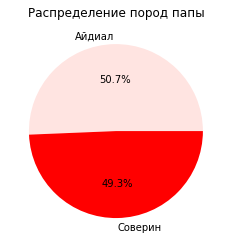

In [43]:
plt.pie(
    ferma_main['порода_папы'].value_counts(),
    labels=['Айдиал', 'Соверин'],
    autopct='%1.1f%%',
    colors=['mistyrose', 'red']
)
plt.title('Распределение пород папы')
plt.grid()
plt.show()

In [44]:
#признак "вкус молока"
ferma_main['вкус_молока'].value_counts()

вкусно       357
не вкусно    255
Name: вкус_молока, dtype: int64

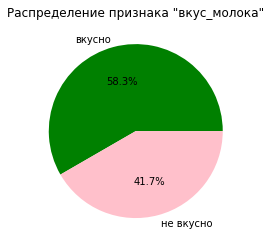

In [45]:
plt.pie(
    ferma_main['вкус_молока'].value_counts(),
    labels=['вкусно', 'не вкусно'],
    autopct='%1.1f%%',
    colors=['green', 'pink']
)
plt.title('Распределение признака "вкус_молока"')
plt.grid()
plt.show()

In [46]:
#признак "возраст"
ferma_main['возраст'].value_counts()

более_2_лет    506
менее_2_лет    106
Name: возраст, dtype: int64

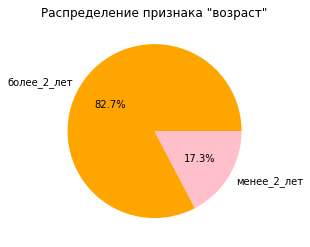

In [47]:
plt.pie(
    ferma_main['возраст'].value_counts(),
    labels=['более_2_лет', 'менее_2_лет'],
    autopct='%1.1f%%',
    colors=['orange', 'pink']
)
plt.title('Распределение признака "возраст"')
plt.grid()
plt.show()

#### Вывод по категориальным признакам
- Порода:

Распределение нормальное, и стремится к соотношению 1:1 (Вис Бик Айдиал - 58.5% записей, РефлешнСоверинг - 41.5% записей)

- Тип пастбища:

Распределение приближено к соотношению 1:1 (Холмистое - 55.7%, равнинное - 44.3%)

- Порода папы:

Распределение данного признака и очень близко к соотношению 1:1 (Айдиал - 50.7%, Соверин - 49.3%)

- Вкус молока:

Распределение нормальное, и стремится к соотношению 1:1 (Вкусно - 58.3%, Не вкусно - 41.7%)

## Корреляционный анализ

#### Взаимосвязь между признаками: расчет коэффициентов корреляции между всеми признаками.

                   удой       эке  сырой_протеин       спо  жирность     белок
удой           1.000000  0.766251       0.444191  0.807889  0.604125  0.016015
эке            0.766251  1.000000       0.382008  0.750448  0.637856 -0.025084
сырой_протеин  0.444191  0.382008       1.000000  0.445330  0.360590  0.218989
спо            0.807889  0.750448       0.445330  1.000000  0.625781  0.089964
жирность       0.604125  0.637856       0.360590  0.625781  1.000000 -0.021898
белок          0.016015 -0.025084       0.218989  0.089964 -0.021898  1.000000


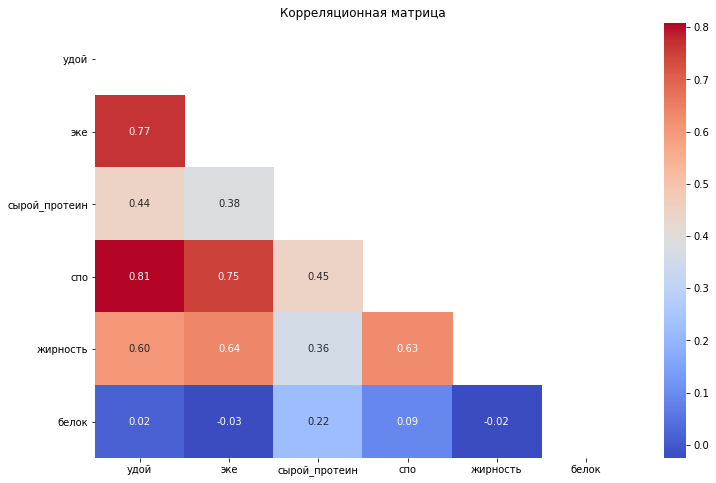

In [48]:
correlation_matrix = ferma_main.drop('id', axis=1).corr()
print(correlation_matrix) 

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title("Корреляционная матрица")
plt.show()

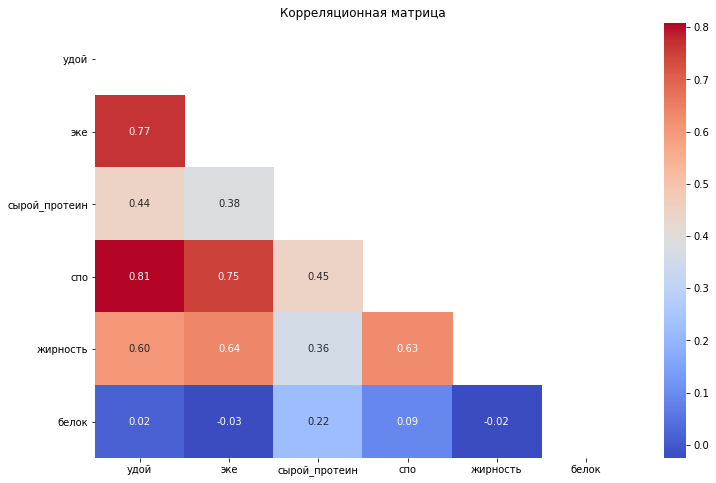

In [49]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title("Корреляционная матрица")
plt.show()

#### Построение диаграмм рассеяния

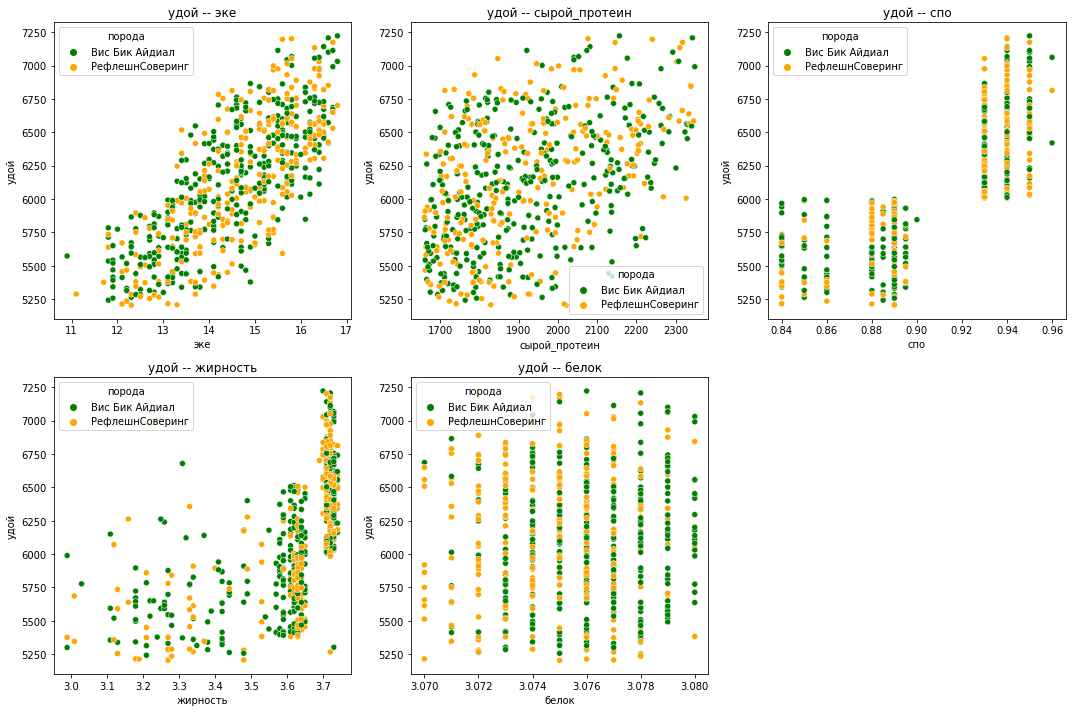

In [50]:
#Построю диаграммы рассеяния для признака удой и всех количественных признаков с учётом значения категориальных признаков.
#Создам список количественных признаков 
quantitative_scatter = ['эке', 'сырой_протеин', 'спо', 'жирность', 'белок']
# Построение диаграмм рассеяния
plt.figure(figsize=(15, 10))

for i, k in enumerate(quantitative_scatter, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=ferma_main, x=k, y='удой', hue='порода', palette=['green', 'orange'])
    plt.title(f'удой -- {k}')

plt.tight_layout()
plt.show()

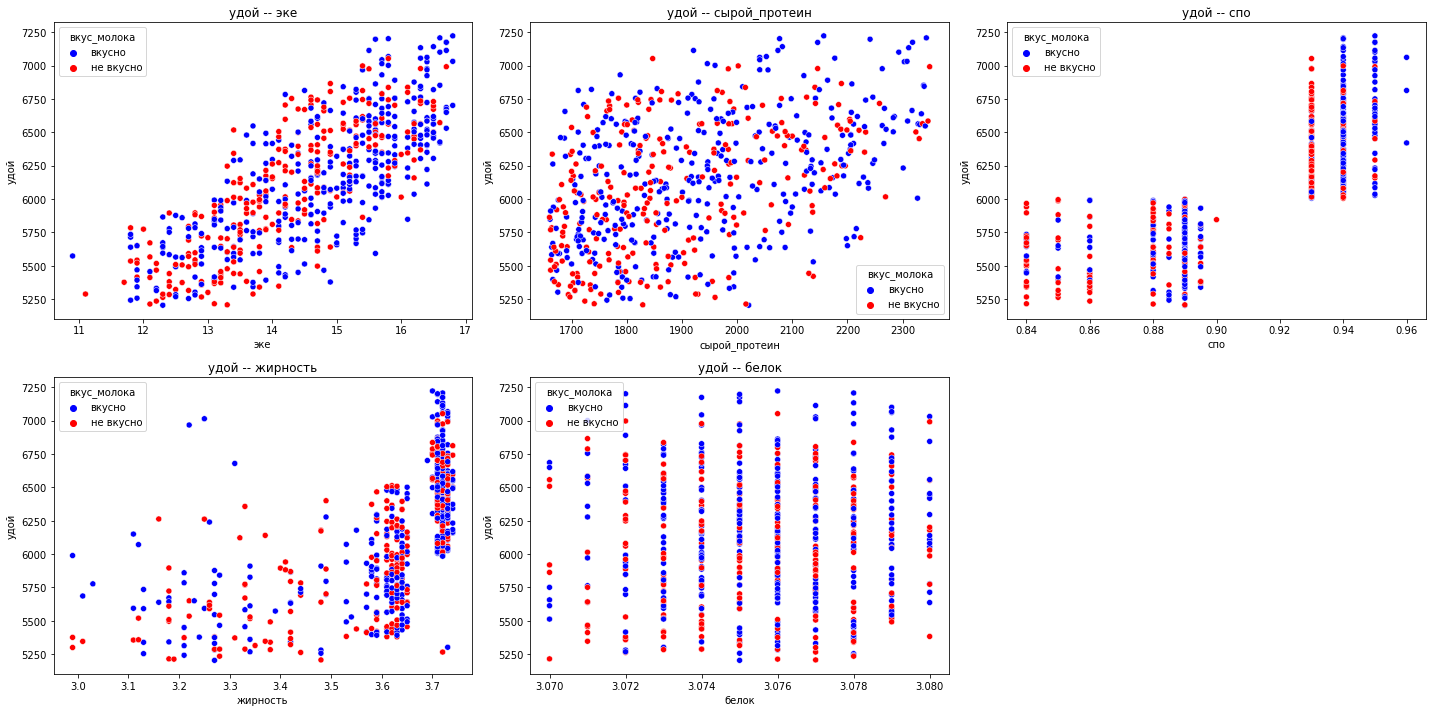

In [51]:
#Создам список количественных признаков 
quantitative_scatter = ['эке', 'сырой_протеин', 'спо', 'жирность', 'белок']

# Построение диаграмм рассеяния
plt.figure(figsize=(20, 10))

for i, feature in enumerate(quantitative_scatter, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=ferma_main, x=feature, y='удой', hue='вкус_молока', palette=['blue', 'red'])
    plt.title(f'удой -- {feature}')

plt.tight_layout()
plt.show()

#### Вывод по корреляционному анализу

- Какой тип взаимосвязи между целевым и входными признаками?
Целевым признаком является пизнак удой - опишем корреляцию между ним и другими признаками

ЭКЕ: Наблюдается положительная взаимосвязь выше умеренного значения. Также можно сказать, что с увеличением "удоя" постепенно увеличивается и "эке". По графикам распределения, корреляция положительная как для одной, так и для другой породы. Коэффициент взаимосвязи составляет 0.76

СЫРОЙ ПРОТЕИН: Взаимосвязь между содержанием сырого протеина и удоем стремится к среднему значению и является умеренно положительной. На графике диаграммы рассеяния виден довольно большой разброс значений, однако можно проследить общий тренд на прямую пропорциональную зависимость. Коэффициент взаимосвязи составляет 0.44

СПО: Из анализа можно сказать, что СПО сильно зависит от целевого признака, тк имеет высокий коэффициент корреляции. В особенности видна резкая тенденция возвышения значений после. Связь похожа на нелинейную, но есть спорный момент в значении спо == 0.91 Коэффициенты взаимосвязи составляет 0.80

ЖИРНОСТЬ: Умеренно положительная зависимость. Более всего связь раскрывается на переходе значений жирность == 3.6 и 3.7. Коэффициент взаимосвязи: 0.60

БЕЛОК: Связь между этим признаком и целевым - нелинейная. Но стоит отметить, что наблюдается зависимость между признаком белок и породой. На меньших значения "белка" - больше значений с породой РефлешнСоверинг, а на бОльших значениях - больше значений породы Вис Бик Айдиал. Коэффициент взаимосвязи: 0.016

- Есть ли нелинейные связи между целевым и входными признаками? Нужно ли вводить в модель дополнительные признаки, чтобы это учесть?

Между целевым и входными признаками связь в основном линейная, но наличие нелинейных связей также возможно для отдельных пород. Явные нелинейные связи не выявлены, в связи с чем добавление новых признаков - не требуется. Кромее признака СПО,он похоже имеет нелинейную связь

- Наблюдается ли мультиколлинеарность между входными признаками?
Корреляционная матрица показала, что между некоторыми входными признаками есть умеренная корреляция, но нет явных признаков сильной мультиколлинеарности, с которой стоило бы справляться.



## Обучение модели линейной регрессии

#### Модель 1

Для начала отбираюи признаки с которыми буду работать и которые можно отсеить. 
Можно избавиться от признака белок, тк с ним связь целевого признака отсутствует и абсолютно нелинейна. Также можно убрать жирность, поскольку признак так же является характеристикой молока и напрямую не связан с таргетом. И признак id для обучения моделей тоже не нужен.

In [52]:
ferma_ml_1 = ferma_main.drop(['id', 'белок', 'жирность'], axis=1)
ferma_ml_1.head()

,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы,вкус_молока,возраст
0,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,вкусно,более_2_лет
1,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,вкусно,менее_2_лет
2,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,не вкусно,более_2_лет
3,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,не вкусно,более_2_лет
4,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,вкусно,менее_2_лет


In [53]:
#разбиваю данные на тренировочную и тестовую выборки
RANDOM_STATE = 42

X = ferma_ml_1.drop('удой', axis=1)
y = ferma_ml_1['удой']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
)

In [54]:
#кодирую категориальные признаки с помощью OneHotEncoder
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы', 'вкус_молока', 'возраст']
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

In [55]:
#масштабирую количественные признаки с помощью StandardScaler
num_col_names = ['эке', 'спо', 'сырой_протеин']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [56]:
#Собираю выборки 
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [57]:
#Обучение модели
model_1 = LinearRegression()
model_1.fit(X_train, y_train)
predictions = model_1.predict(X_test)
r2_1 = r2_score(y_test, predictions)
mse_1 = mean_squared_error(y_test, predictions)
rmse_1 = mean_squared_error(y_test, predictions, squared=False)
mae_1 = mean_absolute_error(y_test, predictions)
print(f'R2_score первой модели: {r2_1}')

R2_score первой модели: 0.8034133611669033


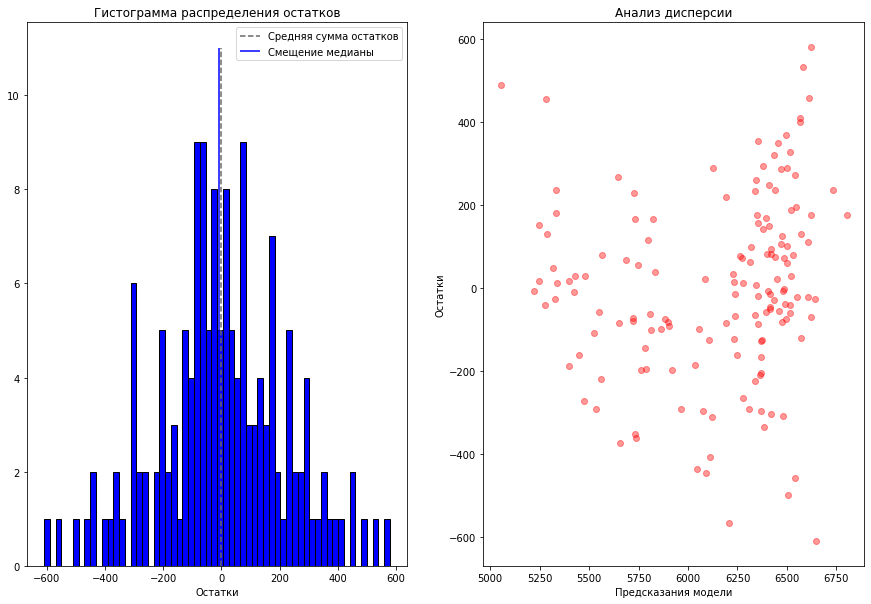

In [58]:
#анализ остатков
#выделяю остатки
residuals_1 = y_test - predictions

#строим гистограмму распределения
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
axes[0].hist(residuals_1, bins=60, color='blue', edgecolor='black')
zero = axes[0].vlines(x=0, colors='dimgrey', ymin=0, ymax=11, linestyles='--', label='Средняя сумма остатков')
median = axes[0].vlines(x=residuals_1.median(), colors='blue', ymin=0, ymax=11, label='Смещение медианы')
axes[0].legend()
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

#строим график дисперсии
axes[1].scatter(predictions, residuals_1, color='red', alpha=0.4)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

##### Выводы по Модели 1

Остатки нормально распределены, график — симметричен. Смещение медианы предсказаний минимально
Устойчивость: в целом, остатки имеют постоянную дисперсию на всём интервале использования модели. Разница между минимумом и максимумом остатков при любых прогнозных значениях модели минимальна. Также, вероятно, модель не очень точно предсказывает значения целевого признака в интервале с 5750 до 6250. Для улучшенного моделирования стоит дополнительно получить информацию по коровам, удой которых находится в интервале значений 5750-6250.
r2_score первой модели == 0.8034133611669033

#### Модель 2

In [59]:
#для начала создам копию датасета
ferma_ml_2 = ferma_main.copy(deep=True)
display(ferma_main.shape)
display(ferma_ml_2.shape)
display(ferma_ml_2.head())

(612, 12)

(612, 12)

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


In [60]:
#Подготовлю данные с которыми буду работать. Преобразую СПО в категориальный признак и преобразую признак ЭКЕ
ferma_ml_2['спо_кат'] = ferma_ml_2['спо'].apply(lambda x: 1 if x > 0.91 else 0)
display(ferma_ml_2['спо_кат'].value_counts())
ferma_ml_2['эке_в_квадрате'] = ferma_ml_2['эке'] ** 2

# Уберу ненужные столбцы
ferma_ml_2 = ferma_ml_2.drop(['id', 'белок', 'жирность', 'эке', 'спо'], axis=1)
ferma_ml_2.head()

1    363
0    249
Name: спо_кат, dtype: int64

,удой,сырой_протеин,порода,тип_пастбища,порода_папы,вкус_молока,возраст,спо_кат,эке_в_квадрате
0,5863,1743,Вис Бик Айдиал,Равнинное,Айдиал,вкусно,более_2_лет,0,201.64
1,5529,2138,Вис Бик Айдиал,Равнинное,Соверин,вкусно,менее_2_лет,0,163.84
2,5810,1854,РефлешнСоверинг,Холмистое,Соверин,не вкусно,более_2_лет,0,196.00
3,5895,2012,РефлешнСоверинг,Холмистое,Айдиал,не вкусно,более_2_лет,0,153.76
4,5302,1675,Вис Бик Айдиал,Равнинное,Соверин,вкусно,менее_2_лет,0,163.84


In [61]:
#разбиваю выборку и применяю OneHotEncoder и StandardScaler
X = ferma_ml_2.drop('удой', axis=1)
y = ferma_ml_2['удой']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
)

cat_col_names = ['порода', 'тип_пастбища', 'порода_папы', 'вкус_молока', 'возраст']
num_col_names = ['эке_в_квадрате', 'спо_кат', 'сырой_протеин']

#работаю категориальными признаки
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

#работаю количественными признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

#собираю выборки и обучаю модель
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

reg_2 = LinearRegression()
reg_2.fit(X_train, y_train)
predictions = reg_2.predict(X_test)
mse_2 = mean_squared_error(y_test, predictions)
rmse_2 = mean_squared_error(y_test, predictions, squared=False)
mae_2 = mean_absolute_error(y_test, predictions)
r2_2 = r2_score(y_test, predictions)
print(f'R2_score второй модели: {r2_2}')

R2_score второй модели: 0.8332519251903154


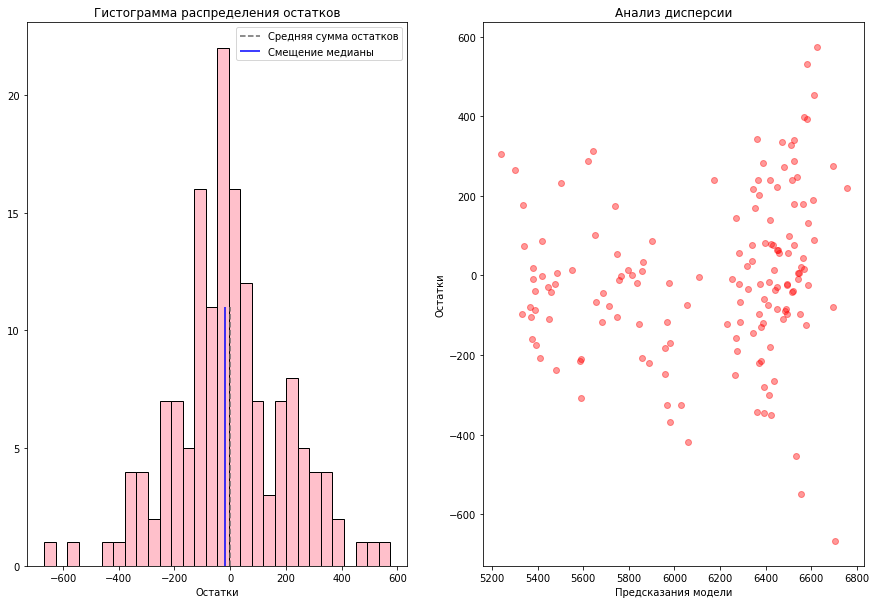

In [62]:
#Анализ остатков. Выделю остатки и строю гистограмму распределения остатков и график анализа дисперсии
residuals_2 = y_test - predictions

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
axes[0].hist(residuals_2, bins=30, color='pink', edgecolor='black')
zero = axes[0].vlines(x=0, colors='dimgrey', ymin=0, ymax=11, linestyles='--', label='Средняя сумма остатков')
median = axes[0].vlines(x=residuals_2.median(), colors='blue', ymin=0, ymax=11, label='Смещение медианы')
axes[0].legend()
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals_2, color='red', alpha=0.4)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

##### Выводы по Модели 2

Случайность: остатки весьма нормально распределены, график — относительно симметричен от самого частого значения. Отклонение от средней суммы остатков 0 - минимально. Устойчивость: дисперсия остатков - нормальная. Разница между минимумом и максимумом остатков при любых прогнозных значениях модели минимальна. r2_score второй модели == 0.8332519251903154 (метрика увеличилась по сравнению с прошлой моделью)

#### Модель 3

In [63]:
# Добавляем в данные признак имя_папы из файла ferma_dad. Подготовлю данные с которыми буду работать и уберу ненужные столбцы.
ferma_full = ferma_main.merge(ferma_dad, on='id')
ferma_full.head()

#преобразуем СПО в категориальный признак
ferma_full['спо_кат'] = ferma_full['спо'].apply(lambda x: 1 if x > 0.91 else 0)
ferma_full['эке_в_квадрате'] = ferma_full['эке'] ** 2

ferma_full = ferma_full.drop(['id', 'белок', 'жирность', 'эке', 'спо'], axis=1)
ferma_full.head()

,удой,сырой_протеин,порода,тип_пастбища,порода_папы,вкус_молока,возраст,имя_папы,спо_кат,эке_в_квадрате
0,5863,1743,Вис Бик Айдиал,Равнинное,Айдиал,вкусно,более_2_лет,Буйный,0,201.64
1,5529,2138,Вис Бик Айдиал,Равнинное,Соверин,вкусно,менее_2_лет,Соловчик,0,163.84
2,5810,1854,РефлешнСоверинг,Холмистое,Соверин,не вкусно,более_2_лет,Барин,0,196.00
3,5895,2012,РефлешнСоверинг,Холмистое,Айдиал,не вкусно,более_2_лет,Буйный,0,153.76
4,5302,1675,Вис Бик Айдиал,Равнинное,Соверин,вкусно,менее_2_лет,Барин,0,163.84


In [64]:
#разбиваю выборку и применяю OneHotEncoder и StandardScaler
X = ferma_full.drop('удой', axis=1)
y = ferma_full['удой']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
)

In [65]:
#применяю OneHotEncoder и StandardScaler
X_train_full = pd.concat([X_train, X_test], ignore_index=True)
y_train_full = pd.concat([y_train, y_test], ignore_index=True)

cat_col_names = ['порода', 'тип_пастбища', 'порода_папы', 'возраст', 'имя_папы', 'вкус_молока']
num_col_names = ['эке_в_квадрате', 'спо_кат', 'сырой_протеин']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [66]:
#обучаю модель
reg_3 = LinearRegression()
reg_3.fit(X_train, y_train)
predictions = reg_3.predict(X_test)
mse_3 = mean_squared_error(y_test, predictions)
rmse_3 = mean_squared_error(y_test, predictions, squared=False)
mae_3 = mean_absolute_error(y_test, predictions)
r2_3 = r2_score(y_test, predictions)
print(f'R2_score третьей модели: {r2_3}')

R2_score третьей модели: 0.8467677260231983


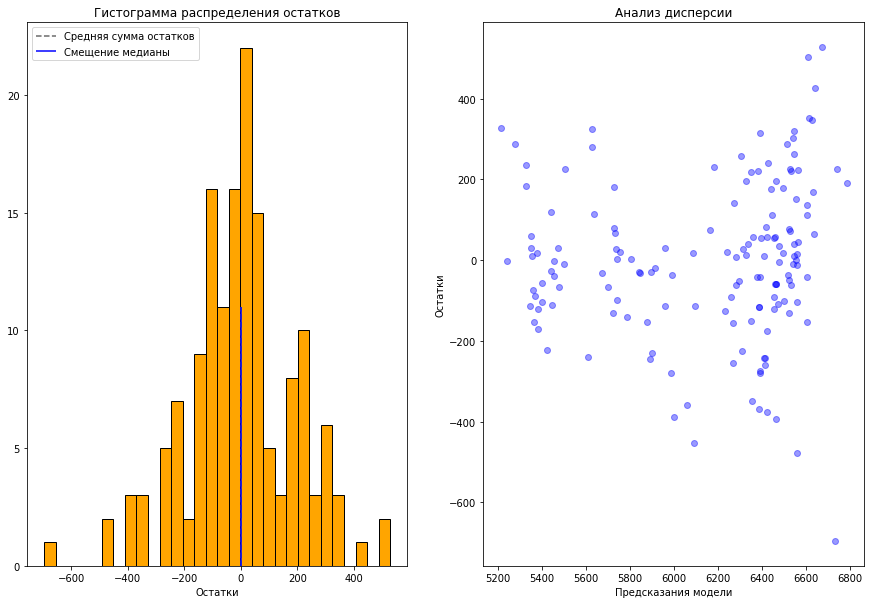

In [67]:
#Анализ остатков. Выделю остатки и строю гистограмму распределения остатков и график анализа дисперсии
residuals_3 = y_test - predictions

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
axes[0].hist(residuals_3, bins=30, color='orange', edgecolor='black')
zero = axes[0].vlines(x=0, colors='dimgrey', ymin=0, ymax=11, linestyles='--', label='Средняя сумма остатков')
median = axes[0].vlines(x=residuals_3.median(), colors='blue', ymin=0, ymax=11, label='Смещение медианы')
axes[0].legend()
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals_3, color='blue', alpha=0.4)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

##### Выводы по Модели 3

Случайность: остатки нормально распределены, график — относительно симметричен от самого частого значения. Отклонение от средней суммы остатков - наименьшее среди всех моделей.
Устойчивость: дисперсия остатков - нормальная. r2_score третьей модели == 0.8467677260231983 (метрика еще увеличилась по сравнению с прошлой моделью - наилучший результат)

#### Сравнение трех моделей

In [68]:
# Сравнение r2_score
scores_compared = {'первой': r2_1, 'второй': r2_2, 'третьей': r2_3}
for k, i in scores_compared.items():
    print(f'R2_score {k} модели: {i}')

# Сравнение остатков
residuals_compared = {'первой': residuals_1, 'второй': residuals_2, 'третьей': residuals_3}
for k, v in residuals_compared.items():
    print(f'Среднее значение остатков {k} модели: {v.mean()}')

R2_score первой модели: 0.8034133611669033
R2_score второй модели: 0.8332519251903154
R2_score третьей модели: 0.8467677260231983
Среднее значение остатков первой модели: -0.2440859222818474
Среднее значение остатков второй модели: -5.6645201958790015
Среднее значение остатков третьей модели: -1.61616845829966


Из сравнения можно сделать выувод, что третья модель показывает наилучшее значение r2_score = 0.8467677260231983, но у первой модели минимальное среднее значение остатков (стремящееся к нулю): -0.2440859222818474

#### Качество каждой модели по трём метрикам: MSE, MAE, RMSE.

In [69]:
#создам цикл,который будет выводить основные метрики
mse_compared = {'первой': mse_1, 'второй': mse_2, 'третьей': mse_3}
for k, v in mse_compared.items():
    print(f'MSE {k} модели: {v}')

print('---')

rmse_compared = {'первой': rmse_1, 'второй': rmse_2, 'третьей': rmse_3}
for k, v in rmse_compared.items():
    print(f'RMSE {k} модели: {v}')

print('---')

mae_compared = {'первой': mae_1, 'второй': mae_2, 'третьей': mae_3}
for k, v in mae_compared.items():
    print(f'MAE {k} модели: {v}')

MSE первой модели: 48710.034678146425
MSE второй модели: 41316.666049668696
MSE третьей модели: 37967.73485485037
---
RMSE первой модели: 220.70349946964237
RMSE второй модели: 203.2650143277704
RMSE третьей модели: 194.85311097041887
---
MAE первой модели: 169.9505685991933
MAE второй модели: 153.51168545643048
MAE третьей модели: 146.4625952324208


In [70]:
# Посчитаем 97% доверительный интервал лучшей модели 
print('97% доверительный интервал =',
      st.norm.interval(confidence=0.97, loc=np.mean(predictions), scale=st.sem(predictions)))

97% доверительный интервал = (6062.938260489588, 6219.065318257076)


Из данных можно сказать что лучшая модель 3-яя, так как:
- MSE третьей модели: 37967.73485485037
- RMSE третьей модели: 194.85311097041887
- MAE третьей модели: 146.4625952324208

В предсказаниях ошибается в среднем на 194 кг

#### Модель 4

In [71]:
#для начала создам копию датасета
cow_buy_ml = cow_buy.copy(deep=True)

#считаем среднее значение каждого недостающего признака и увеличиваем их на 5%. Добавлю недостающие признаки в датасет cow_buy и преобразую их
mean_values = ferma_main[['эке', 'сырой_протеин', 'спо']].mean()
new_values = mean_values * 1.05

cow_buy_ml['эке'] = new_values['эке']
cow_buy_ml['эке_в_квадрате'] = cow_buy_ml['эке'] ** 2
cow_buy_ml['сырой_протеин'] = new_values['сырой_протеин']
cow_buy_ml['спо'] = new_values['спо']
cow_buy_ml['спо_кат'] = cow_buy_ml['спо'].apply(lambda x: 1 if x > 0.91 else 0)

cow_buy_ml = cow_buy_ml.drop(['текущий_белок', 'эке', 'спо'], axis=1)
X_train_full = X_train_full.drop('вкус_молока', axis=1)

# Проверка
display(cow_buy_ml.shape)
display(X_train_full.shape)
display(cow_buy_ml.head())
display(X_train_full.head())

#Кодирую и масштабируем признаки новой обучающей и тестовой выборки
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы', 'возраст', 'имя_папы', 'спо_кат']
num_col_names = ['эке_в_квадрате', 'сырой_протеин']

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train_full[cat_col_names])
X_test_ohe = encoder.transform(cow_buy_ml[cat_col_names])
encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full[num_col_names])
X_test_scaled = scaler.transform(cow_buy_ml[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train_full = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_full = pd.concat([X_test_ohe, X_test_scaled], axis=1)

(20, 9)

(612, 8)

,порода,тип_пастбища,порода_папы,имя_папы,текущая_жирность,возраст,эке_в_квадрате,сырой_протеин,спо_кат
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,более_2_лет,233.208082,2018.417402,1
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,менее_2_лет,233.208082,2018.417402,1
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,более_2_лет,233.208082,2018.417402,1
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,более_2_лет,233.208082,2018.417402,1
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,более_2_лет,233.208082,2018.417402,1


,сырой_протеин,порода,тип_пастбища,порода_папы,возраст,имя_папы,спо_кат,эке_в_квадрате
0,1984,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет,Буйный,1,198.81
1,1984,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет,Буйный,1,246.49
2,2067,Вис Бик Айдиал,Холмистое,Айдиал,более_2_лет,Буйный,1,249.64
3,2091,Вис Бик Айдиал,Равнинное,Соверин,более_2_лет,Соловчик,1,243.36
4,1721,РефлешнСоверинг,Равнинное,Соверин,более_2_лет,Барин,0,182.25


In [72]:
#обучаю модель
final_reg = LogisticRegression()
final_reg.fit(X_train_full, y_train_full)
pred = final_reg.predict(X_test_full)
print(pred)

[6755 6248 6173 6501 6501 6755 6755 6248 6173 6501 6084 6755 6755 6122
 6173 6501 6084 6755 6248 6501]


In [73]:
cow_buy['прогноз_удоя'] = pred
cow_buy

,порода,тип_пастбища,порода_папы,имя_папы,текущая_жирность,текущий_белок,возраст,прогноз_удоя
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6755
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6248
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6173
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6501
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6501
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,6755
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6755
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6248
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6173
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6501


#### Выводы по задаче регрессии

Выявлена лучшая модель из трех, показатели которой составляют:

- MAE - 146.4625952324208
- MSE - 37967.73485485037
- RMSE - 194.85311097041887
- 97% доверительный интервал = (6062.938260489588, 6219.065318257076)

Также, собрала тренировочную и тестовую выборки и протестировала модель на тестовой выборке. Получены предсказания по всем коровам продавца. По условию задачи регрессии, можно уже на данном этапе рекомендовать фермеру для покупки всех коров(так как каждая из них даст более 6000 кг удоя в год).

## Обучение модели логистической регрессии

In [74]:
#для начала создаю копию основного датасета и подготавливаю признаки
ferma_log = ferma_main.copy(deep=True)

ferma_log['вкус_молока_кат'] = ferma_log['вкус_молока'].apply(lambda x: 1 if x == 'вкусно' else 0)
ferma_log['спо_кат'] = ferma_log['спо'].apply(lambda x: 1 if x > 0.91 else 0)
ferma_log['эке_в_квадрате'] = ferma_log['эке'] ** 2
ferma_log = ferma_log.drop(['id', 'удой', 'вкус_молока', 'эке', 'спо'], axis=1)
ferma_log.head()

,сырой_протеин,порода,тип_пастбища,порода_папы,жирность,белок,возраст,вкус_молока_кат,спо_кат,эке_в_квадрате
0,1743,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,более_2_лет,1,0,201.64
1,2138,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,менее_2_лет,1,0,163.84
2,1854,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,более_2_лет,0,0,196.00
3,2012,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,более_2_лет,0,0,153.76
4,1675,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,менее_2_лет,1,0,163.84


In [75]:
#выделю целовой признак, а ткже сразу сделаю кодирование и масштабирование
X = ferma_log.drop('вкус_молока_кат', axis=1)
y = ferma_log['вкус_молока_кат']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train_full = pd.concat([X_train, X_test], ignore_index=True)
y_train_full = pd.concat([y_train, y_test], ignore_index=True)

cat_col_names = ['порода', 'тип_пастбища', 'порода_папы', 'возраст', 'спо_кат']
num_col_names = ['жирность', 'белок', 'эке_в_квадрате', 'сырой_протеин']

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [76]:
#обучаю модель
clf = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

clf_accuracy = accuracy_score(y_pred, y_test)
clf_recall = recall_score(y_pred, y_test)
clf_precision = precision_score(y_pred, y_test)

print(f'Accuracy: {clf_accuracy}')
print(f'Recall: {clf_recall}')
print(f'Precision: {clf_precision}')

Accuracy: 0.5947712418300654
Recall: 0.6216216216216216
Precision: 0.7752808988764045


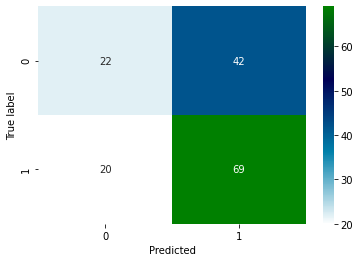

In [77]:
#пстроение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='ocean_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

Precision имеет значение - 0.7752808988764045, что не очень плохо, но стоит обратить внимание на ошибки первого рода. Recall и Accuracy близки к показателям "случайной модели", что не совсем хорошо. Из матрицы видно, что 42 ошибок первого рода, по отношению к 69 верноположительным предсказаниям. Нужно минимизировать количество ошибок.

#### Анализ модели логистической регрессии

Ошибка первого рода - критичнее всего при покупке коров, так как перед нами стоит задача продать фермеру коров с вкусным молоком.

- Recall:
В метрике задействуются ответы TP и FN. Ошибки второго рода - не критичны для нас, поскольку нет страшного в том, что мы не предложим фермеру несколько коров, у которых вкусное молоко. Хуже будет, если предложить фермеру коров у которых не вкусное молоко.

- Precision:

В метрике задействуются ответы TP и FP. Количество FP (ошибок первого рода) нужно сводить к минимуму, ибо они критичны. В таком случае можно сказать, что нам нужно максимизировать метрику Precision.

#### Прогноз вкуса молока

In [78]:
#сначала создам копию датасета
cow_buy_ml_2 = cow_buy.copy(deep=True)

#добавлю недостающие признаки в датасет cow и поработаю с ними
cow_buy_ml_2['эке'] = new_values['эке']
cow_buy_ml_2['эке_в_квадрате'] = cow_buy_ml_2['эке'] ** 2
cow_buy_ml_2['сырой_протеин'] = new_values['сырой_протеин']
cow_buy_ml_2['спо'] = new_values['спо']
cow_buy_ml_2['спо_кат'] = cow_buy_ml_2['спо'].apply(lambda x: 1 if x > 0.91 else 0)

cow_buy_ml_2.rename(columns={'текущая_жирность': 'жирность', 'текущий_белок': 'белок'}, inplace=True)
cow_buy_ml_2 = cow_buy_ml_2.drop(['имя_папы', 'эке', 'спо'], axis=1)

cow_buy_ml_2.head()

,порода,тип_пастбища,порода_папы,жирность,белок,возраст,прогноз_удоя,эке_в_квадрате,сырой_протеин,спо_кат
0,Вис Бик Айдиал,Холмистое,Айдиал,3.58,3.076,более_2_лет,6755,233.208082,2018.417402,1
1,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.081,менее_2_лет,6248,233.208082,2018.417402,1
2,РефлешнСоверинг,Равнинное,Соверин,3.59,3.074,более_2_лет,6173,233.208082,2018.417402,1
3,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.061,более_2_лет,6501,233.208082,2018.417402,1
4,РефлешнСоверинг,Равнинное,Айдиал,3.64,3.074,более_2_лет,6501,233.208082,2018.417402,1


In [79]:
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы', 'возраст', 'спо_кат']
num_col_names = ['жирность', 'белок', 'эке_в_квадрате', 'сырой_протеин']

#применяю OneHotEncoder и StandardScaler
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train_full[cat_col_names])
X_test_ohe = encoder.transform(cow_buy_ml_2[cat_col_names])
encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full[num_col_names])
X_test_scaled = scaler.transform(cow_buy_ml_2[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train_full = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_full = pd.concat([X_test_ohe, X_test_scaled], axis=1)

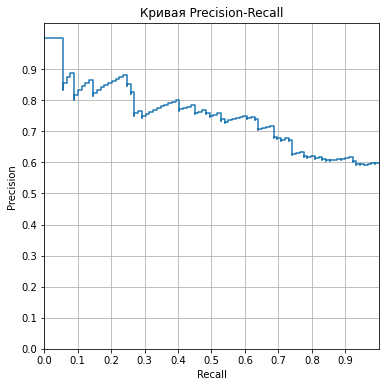

In [80]:
#прогноз подбора класса
y_proba = clf.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))
plt.grid()
plt.title('Кривая Precision-Recall')
plt.show()


In [81]:
#выведем вероятность класса predict_proba()
y_proba = clf.predict_proba(X_test)[:, 1]

proba_data = pd.DataFrame(zip(y_test, y_proba),
                          columns=['y_test', 'y_proba']).sort_values(by='y_proba', ascending=False)

proba_data.head()
# Функция расчета метрик для каждого порога
def threshold_choice(threshold_list, proba_df):
    result_df = pd.DataFrame(columns=['порог', 'precision', 'recall', 'количество_FP', 'число_предсказанных_объектов',
                                      'всего_объектов_класса_1'])

    for threshold in threshold_list:
        column_name = 'y_pred_' + str(threshold)
        precision = proba_df.loc[proba_df[column_name] == 1, 'y_test'].mean()
        predicted_objects = proba_df[column_name].sum()
        # Всего объектов класса 1
        total_objects_class_1 = proba_df['y_test'].sum()
        recall = proba_df.loc[(proba_df[column_name] == 1) & (proba_df['y_test'] == 1)].shape[
                     0] / total_objects_class_1

        #FP
        false_positives = proba_df.loc[(proba_df[column_name] == 1) & (proba_df['y_test'] == 0)].shape[0]

        #добаввлю результаты в датафрейм
        result_df = result_df.append({
            'порог': threshold,
            'precision': precision,
            'recall': recall,
            'количество_FP': false_positives,
            'число_предсказанных_объектов': predicted_objects,
            'всего_объектов_класса_1': total_objects_class_1,
        }, ignore_index=True)

    return result_df

In [82]:
#для начала сделаю общий перебор порогов
proba_data_1 = proba_data.copy(deep=True)

thresholds_1 = [round(i, 2) for i in np.linspace(0.1, 1, num=10, endpoint=False)]
columns = []

for i in thresholds_1:
    columns.append('y_pred_' + str(i))
    proba_data_1['y_pred_' + str(i)] = proba_data_1['y_proba'].apply(lambda x: 1 if x > i else 0)

threshold_choice(thresholds_1, proba_data_1)

,порог,precision,recall,количество_FP,число_предсказанных_объектов,всего_объектов_класса_1
0,0.10,0.581699,1.000000,64.0,153.0,89.0
1,0.19,0.581699,1.000000,64.0,153.0,89.0
2,0.28,0.598639,0.988764,59.0,147.0,89.0
3,0.37,0.592857,0.932584,57.0,140.0,89.0
4,0.46,0.606557,0.831461,48.0,122.0,89.0
5,0.55,0.670103,0.730337,32.0,97.0,89.0
6,0.64,0.750000,0.505618,15.0,60.0,89.0
7,0.73,0.774194,0.269663,7.0,31.0,89.0
8,0.82,1.000000,0.056180,0.0,5.0,89.0
9,0.91,NaN,0.000000,0.0,0.0,89.0


Из таблицы можно сказать, что если порог ниже 0.64, то количество FP большое, однако значения выше порога 0.73 - слишком сильно влияют на метрику recall. Проанализирую интервал детальнее.

In [83]:
proba_data_2 = proba_data.copy(deep=True)

thresholds_2 = [round(i, 2) for i in np.linspace(0.64, 0.75, num=11, endpoint=False)]

columns = []

for i in thresholds_2:
    columns.append('y_pred_' + str(i))
    proba_data_2['y_pred_' + str(i)] = proba_data_2['y_proba'].apply(lambda x: 1 if x > i else 0)

threshold_choice(thresholds_2, proba_data_2)

,порог,precision,recall,количество_FP,число_предсказанных_объектов,всего_объектов_класса_1
0,0.64,0.750000,0.505618,15.0,60.0,89.0
1,0.65,0.745763,0.494382,15.0,59.0,89.0
2,0.66,0.759259,0.460674,13.0,54.0,89.0
3,0.67,0.754717,0.449438,13.0,53.0,89.0
4,0.68,0.770833,0.415730,11.0,48.0,89.0
5,0.69,0.795455,0.393258,9.0,44.0,89.0
6,0.70,0.780488,0.359551,9.0,41.0,89.0
7,0.71,0.769231,0.337079,9.0,39.0,89.0
8,0.72,0.750000,0.303371,9.0,36.0,89.0
9,0.73,0.774194,0.269663,7.0,31.0,89.0


Из данного анализа можно сказать, что порог 0.69 является самым оптимальным, поскольку при нем минимизировалось количество FP до 9, сохранив половину предсказанных ответов. Да, метрика recall не высока, но наша задача - стремиться к повышению precision при низком количестве FP, что и позволяет сделать данный порог

In [84]:
#dыделяю оптимальный порог
OPTIMAL_THRESHOLD = 0.69

#применение его к предсказанным вероятностям
y_pred_threshold = (y_proba > OPTIMAL_THRESHOLD).astype(int)

clf_accuracy_new = accuracy_score(y_test, y_pred_threshold)
clf_recall_new = recall_score(y_test, y_pred_threshold)
clf_precision_new = precision_score(y_test, y_pred_threshold)

print(f'Old Accuracy: {clf_accuracy}')
print(f'Old Recall: {clf_recall}')
print(f'Old Precision: {clf_precision}')
print('---')
print(f'New Accuracy: {clf_accuracy_new}')
print(f'New Recall: {clf_recall_new}')
print(f'New Precision: {clf_precision_new}')
print('---')

Old Accuracy: 0.5947712418300654
Old Recall: 0.6216216216216216
Old Precision: 0.7752808988764045
---
New Accuracy: 0.5882352941176471
New Recall: 0.39325842696629215
New Precision: 0.7954545454545454
---


In [85]:
clf.fit(X_train_full, y_train_full)
y_proba = clf.predict_proba(X_test_full)[:, 1]
predictions_final = (y_proba > OPTIMAL_THRESHOLD).astype(int)

cow_buy['прогнозируемый_вкус_молока'] = predictions_final
cow_buy['прогнозируемый_вкус_молока'] = cow_buy['прогнозируемый_вкус_молока'].apply(lambda x: 'вкусно' if x == 1 else 'не вкусно')
to_buy = cow_buy.query('прогнозируемый_вкус_молока == "вкусно"')
cow_buy

,порода,тип_пастбища,порода_папы,имя_папы,текущая_жирность,текущий_белок,возраст,прогноз_удоя,прогнозируемый_вкус_молока
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6755,вкусно
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6248,не вкусно
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6173,не вкусно
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6501,не вкусно
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6501,не вкусно
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,6755,не вкусно
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6755,вкусно
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6248,не вкусно
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6173,не вкусно
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6501,вкусно


In [86]:
to_buy

,порода,тип_пастбища,порода_папы,имя_папы,текущая_жирность,текущий_белок,возраст,прогноз_удоя,прогнозируемый_вкус_молока
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6755,вкусно
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6755,вкусно
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6501,вкусно
16,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,6084,вкусно


Из таблицы можно сделать вывод, что эти 4 коровы, будут самым лучшим вариантом для приобретения фермеру.

## Итоговые выводы

В ходе работы над проектом была разработана модель машинного обучения, которая сможет помочь фермеру принимать объективное решение о покупке коров на ферму. Рекомендуемые коровы к покупке:

In [87]:
to_buy

,порода,тип_пастбища,порода_папы,имя_папы,текущая_жирность,текущий_белок,возраст,прогноз_удоя,прогнозируемый_вкус_молока
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6755,вкусно
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6755,вкусно
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6501,вкусно
16,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,6084,вкусно


В ходе исследования я сделала:

Импортировала нужные библиотеки

1. Загрузку и подготовку данных

- ferma_main

Обнаружила 5 явных дубликатов. Определила, что стоит изменить названия столбцов и привести их к единому виду. Сделала проверку на пропущенные значений и выявила, что их нет. Определили, что с типами данных все в порядке.

- ferma_dad

Определила, стоит изменить названия столбцов и привести их к единому виду. В остальном данные оказались в порядке. 

- cow_buy

Обнаружила 4 явных дубликата (убирать их не буду, поскольку данных в датасете мало, как и признаков. Вполне вероятно, что данные и признаки сходятся для разных коров). Определила, что стоит изменить названия столбцов и привести их к единому виду. Пропущенных значений не было. Определили, что с типами данных все в порядке.

2. Предобработка данных

Названия столбцов привела к единому, удобному виду. Убрала неявные и явные дубликаты из датасета ferma_main 

3. Исследовательский анализ данных

Выявили, что почти все признаки распределены нормально и не требуют особых корректировок выбросов. Убрали аномальное значение признака [удой] == 45616. В распределение категориальных переменных критических изменений внесено не было. 

В ходе работы над проектом была разработана модель машинного обучения, которая сможет помочь заказчику управлять рисками и принимать объективное решение о покупке коров на ферму. Рекомендуемые коровы к покупке:

города	тип_пастбища	порода_папы	имя_папы	текущая_жирность	текущий_белок	возраст	ожидаемый_удой	ожидаемый_вкус_молока
Вис Бик Айдиал	Холмистое	Айдиал	Геркулес	3.58	3.076	более 2 лет	6755	вкусно
Вис Бик Айдиал	Холмистое	Айдиал	Геркулес	3.58	3.076	более 2 лет	6755	вкусно
РефлешнСоверинг	Холмистое	Айдиал	Буйный	3.40	3.079	менее 2 лет	6501	вкусно
Вис Бик Айдиал	Холмистое	Соверин	Соловчик	3.73	3.079	более 2 лет	6084	вкусно

4. Корреляционный анализ данных

ЭКЕ: Наблюдается положительная взаимосвязь выше умеренного значения. Также можно сказать, что с увеличением "удоя" постепенно увеличивается и "эке". По графикам распределения, корреляция положительная как для одной, так и для другой породы. Коэффициент взаимосвязи составляет 0.76

СЫРОЙ ПРОТЕИН: Взаимосвязь между содержанием сырого протеина и удоем стремится к среднему значению и является умеренно положительной. На графике диаграммы рассеяния виден довольно большой разброс значений, однако можно проследить общий тренд на прямую пропорциональную зависимость. Коэффициент взаимосвязи составляет 0.44

СПО: Из анализа можно сказать, что СПО сильно зависит от целевого признака, тк имеет высокий коэффициент корреляции. В особенности видна резкая тенденция возвышения значений после. Связь похожа на нелинейную, но есть спорный момент в значении спо == 0.91 Коэффициенты взаимосвязи составляет 0.80

ЖИРНОСТЬ: Умеренно положительная зависимость. Более всего связь раскрывается на переходе значений жирность == 3.6 и 3.7. Коэффициент взаимосвязи: 0.60

БЕЛОК: Связь между этим признаком и целевым - нелинейная. Но стоит отметить, что наблюдается зависимость между признаком белок и породой. На меньших значения "белка" - больше значений с породой РефлешнСоверинг, а на бОльших значениях - больше значений породы Вис Бик Айдиал. Коэффициент взаимосвязи: 0.016

Между целевым и входными признаками связь в основном линейная, но наличие нелинейных связей также возможно для отдельных пород. Явные нелинейные связи не выявлены, в связи с чем добавление новых признаков - не требуется. Кромее признака СПО,он похоже имеет нелинейную связь.
Корреляционная матрица показала, что между некоторыми входными признаками есть умеренная корреляция, но нет явных признаков сильной мультиколлинеарности, с которой стоило бы справляться.

5. Решение задачи регресии (предсказание удоя)

Обучила 3 модели линейной регрессии и проанализировали их остатки. Выявила лучшую модель из трех на валидационной выборке, показатели которой:

- MAE - 146.4625952324208
- MSE - 37967.73485485037
- RMSE - 194.85311097041887
- 97% доверительный интервал = (6062.938260489588, 6219.065318257076)

Также, собрала тренировочную и тестовую выборки и протестировала модель на тестовой выборке. Получены предсказания по всем коровам продавца. По условию задачи регрессии, можно уже на данном этапе рекомендовать фермеру для покупки всех коров(так как каждая из них даст более 6000 кг удоя в год). Добавила столбец с предсказаниями в таблицу продавца. 

6. Решение задачи классификации (предсказания вкуса молока)

Подобрала параметры и обучила модель логистической регрессии, проанализировала модель и минимизировали количество критических ошибок первого рода с 42 до 9, подобрав новый порог для вероятности предсказаний. Определила 4-х коров, чье молоко предсказано как "вкусное". Отобрала для рекомендации 4 коровы, учитывая оба условия заказчика.